In [20]:
import sys, os; sys.path.insert(1, os.path.join(sys.path[0], '..'))
from hex.graph_hex_board import GraphHexBoard
import numpy as np
import torch
from matplotlib.cm import ScalarMappable

class GHB(GraphHexBoard):
    @property
    def cell_colours(self):
        sm = ScalarMappable(cmap='viridis')
        return sm.to_rgba(self.x)

class AverageMeter(object):
    def __init__(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

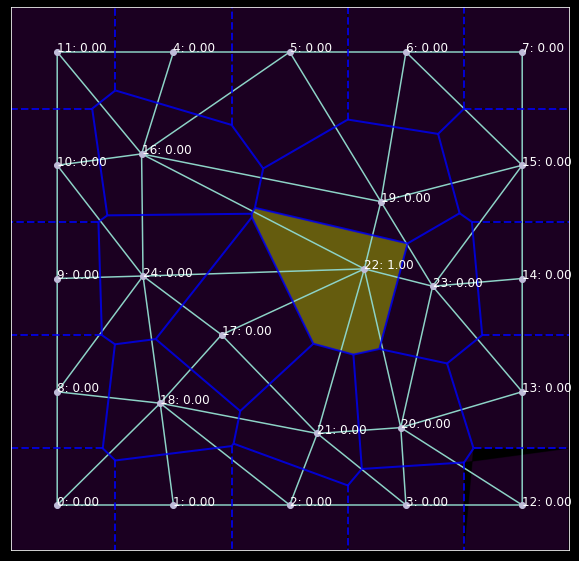

In [21]:
from itertools import combinations, product

def secure_2hop(n_nodes, A, edge_index, side_n):
    # label the secure 2 hop faces
    y = torch.zeros(n_nodes)
    y[side_n] = 1.
    m = edge_index[0] == side_n
    one_hop = edge_index[1, m]
    y = A @ (A @ y)
    y[side_n] = 0.
    y[one_hop] = 0.

    return (y >= 2.).nonzero().squeeze().tolist()

def independent_s2h_pairs(s_2hop, edge_index, side_n):
    # get the side connection sets for each 2-hop side connections
    csets = {}
    for n in s_2hop:
        a = set(edge_index[1, edge_index[0] == n].tolist())
        b = set(edge_index[1, edge_index[0] == side_n].tolist())
        csets[n] = a & b

    pset = combinations(s_2hop, 2)

    #find independent pairs of secure 2-hop side connections 
    i2hsc = []
    for s in pset:
        a, b = csets[s[0]], csets[s[1]]
        ndups = len(a & b)
        if (len(a) + len(b) - ndups) >= 4:
            i2hsc.append(s)
    
    return i2hsc

def find_winner(ns):
    n_nodes = ns**2 + 4
    l_side = n_nodes - 2
    r_side = n_nodes - 1
    # setup the board
    board = GHB.new_vortex_board(ns)
    A = torch.sparse_coo_tensor(board.edge_index, torch.ones_like(board.edge_index[0]), dtype=torch.float)
    edge_index = board.edge_index

    board.x = torch.zeros(n_nodes)
    ls_2hop = secure_2hop(n_nodes, A, edge_index, l_side)
    rs_2hop = secure_2hop(n_nodes, A, edge_index, r_side)
    board.x[ls_2hop + rs_2hop] = 1.

    lsp = independent_s2h_pairs(ls_2hop, edge_index, l_side)
    rsp = independent_s2h_pairs(rs_2hop, edge_index, r_side)
    opp_pairs = product(lsp, rsp)

    def connectors(A, ndx):
        return (A.to_dense()[ndx].sum(dim=0) == len(ndx)).nonzero().squeeze()

    for scn in opp_pairs:
        ndx = list(scn[0]) + list(scn[1])
        cn = connectors(A, ndx)
        if cn.numel() == 1:
            return board, cn.item()

    return None


ns = 5
res = None
while(res is None):
    res = find_winner(ns)

board, n = res
board.x = torch.zeros_like(board.node_attr[:,0])
board.x[n] = 1.
board.plot()    

In [26]:
from torch.utils.data import TensorDataset
from torch_geometric.utils import get_laplacian

def wi8_features(ns, edge_index, dim):    
    n_nodes = ns**2 + 4
    l_side = n_nodes - 2
    r_side = n_nodes - 1

    L = get_laplacian(edge_index, normalization='sym')
    L = torch.sparse_coo_tensor(L[0], L[1])

    # features
    n_steps = dim // 2
    steps = []

    x = torch.zeros_like(board.node_attr[:,0])
    x[l_side] = 1.
    for i in range(n_steps):
        steps.append(x.clone().detach())
        if i < n_steps-1:
            x = L @ x

    x = torch.zeros_like(board.node_attr[:,0])
    x[r_side] = 1.
    for i in range(n_steps):
        steps.append(x.clone().detach())
        if i < n_steps-1:
            x = L @ x

    x = torch.stack(steps, dim=1)
    
    return x


def get_wi8(ns):   
    res = None
    while(res is None):
        res = find_winner(ns)
    return res 

class WI8_DS(TensorDataset):
    def __init__(self, sample_boards=1000, nsides=5, dim=20):   
        self.sample_boards = sample_boards
        self.nsides = nsides
        self.dim = dim

        x, y = [], []

        for i in range(sample_boards):
            board, n = get_wi8(nsides)
            xs = wi8_features(nsides, board.edge_index, dim)
            x.append(xs)
            y.append(n)

        x = torch.stack(x, dim=0)
        y = torch.tensor(y, dtype=torch.long)
        super().__init__(x, y)


class WI8Raw_DS(TensorDataset):
    def __init__(self, sample_boards=1000, nsides=5, dim=20):   
        self.sample_boards = sample_boards
        self.nsides = nsides
        self.dim = dim
        n_nodes = nsides**2 + 4
        l_side = n_nodes - 2
        r_side = n_nodes - 1

        x, y, edge_index = [], [], []

        for i in range(sample_boards):
            board, n = get_wi8(nsides)
            xs = torch.zeros(n_nodes, 2)
            xs[l_side, 0] = 1.
            xs[r_side, 1] = 1.
            x.append(xs)
            y.append(n)
            edge_index.append(board.edge_index)

        x = torch.stack(x, dim=0)
        y = torch.tensor(y, dtype=torch.long)
        edge_index = torch.stack(edge_index, dim=0)
        super().__init__(x, y, edge_index)        

In [35]:
nsides=5
dim=20

# train_ds = WI8_DS(sample_boards=2000, nsides=nsides, dim=dim)
# val_ds = WI8_DS(sample_boards=200, nsides=nsides, dim=dim)

train_ds = WI8Raw_DS(sample_boards=2000, nsides=nsides, dim=dim)
val_ds = WI8Raw_DS(sample_boards=200, nsides=nsides, dim=dim)

In [43]:
from torch.nn import Linear, Module, LogSoftmax, Softmax
from torch_geometric.nn import ChebConv

class VorNet_MLP(Module):
    """
    top-1 accuracy 98.44% on 25 node board
    """
    def __init__(self, in_features=20):
        super().__init__()
        self.lin1 = Linear(in_features=in_features, out_features=64)
        self.lin2 = Linear(in_features=64, out_features=1)
        self.train_readout = LogSoftmax(dim=1)
        self.readout = Softmax(dim=1)

    def forward(self, x):
        B, N, F = x.shape

        x = x.view(B*N, F)
        x = self.lin1(x)
        x = x.relu()
        out = self.lin2(x)
        
        out = out.view(B, N)
        readout = self.train_readout if self.training else self.readout
        out = readout(out)

        return out

class VorNet_Cheb(Module):
    """
    top-1 accuracy 98.83% on 25 node board
    """
    def __init__(self):
        super().__init__()
        self.cheb = ChebConv(in_channels=2, out_channels=64, K=10, normalization='sym')
        self.lin = Linear(in_features=64, out_features=1)
        self.train_readout = LogSoftmax(dim=1)
        self.readout = Softmax(dim=1)

    def forward(self, x, edge_index):
        B, N, F = x.shape
        edge_index_batch = torch.arange(start=0, end=B*N, step=N, device=x.device)
        edge_index_batch = edge_index_batch.view(-1,1,1).expand_as(edge_index)
        edge_index += edge_index_batch
        edge_index = edge_index.permute(1,0,2).reshape(2, -1)
        x = x.view(B*N, F)

        x = self.cheb(x, edge_index)
        x = x.relu()
        out = self.lin(x)
        
        out = out.view(B, N)
        readout = self.train_readout if self.training else self.readout
        out = readout(out)

        return out

In [49]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VorNet_Cheb().to(device)

In [50]:

from torch.utils.data import DataLoader
from torch.nn import NLLLoss
from sklearn.metrics import top_k_accuracy_score

LR = 1e-4
EPOCHS = 10000
BATCH_SIZE = 64

criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = AverageMeter()
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    print("Epoch {}".format(epoch))

    model.train()
    for x, y, edge_index in train_dl:
        x, y, edge_index = x.to(device=device), y.to(device=device), edge_index.to(device=device)
        out = model(x, edge_index)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.update(loss.item())
    
    print("\ttrain - loss: {}".format(train_loss))

    model.eval()
    with torch.no_grad():
        for x, y, edge_index in val_dl:
            x, y, edge_index = x.to(device=device), y.to(device=device), edge_index.to(device=device)
            out = model(x, edge_index)
            loss = criterion(out, y)
            val_loss.update(loss.item())
            val_accuracy.update(top_k_accuracy_score(y.cpu().numpy(), out.squeeze().cpu().numpy(), k=1, labels=np.arange(29)))

    print("\tval - loss: {}, accuracy: {:.2f}%".format(val_loss.avg, val_accuracy.avg*100))

Epoch 0
	train - loss: 3.33e+00
	val - loss: -0.03610346466302872, accuracy: 44.53%
Epoch 1
	train - loss: 3.31e+00
	val - loss: -0.036891547963023186, accuracy: 55.08%
Epoch 2
	train - loss: 3.29e+00
	val - loss: -0.03772658109664917, accuracy: 58.20%
Epoch 3
	train - loss: 3.26e+00
	val - loss: -0.03862486779689789, accuracy: 58.20%
Epoch 4
	train - loss: 3.24e+00
	val - loss: -0.039595507085323334, accuracy: 57.81%
Epoch 5
	train - loss: 3.21e+00
	val - loss: -0.04065823741257191, accuracy: 58.20%
Epoch 6
	train - loss: 3.19e+00
	val - loss: -0.04183006752282381, accuracy: 58.59%
Epoch 7
	train - loss: 3.16e+00
	val - loss: -0.04312863200902939, accuracy: 58.20%
Epoch 8
	train - loss: 3.13e+00
	val - loss: -0.044568903744220734, accuracy: 58.20%
Epoch 9
	train - loss: 3.09e+00
	val - loss: -0.04616723861545324, accuracy: 58.20%
Epoch 10
	train - loss: 3.06e+00
	val - loss: -0.04793732054531574, accuracy: 57.42%
Epoch 11
	train - loss: 3.02e+00
	val - loss: -0.04989252891391516, accu